### Using LDA for classification

In [2]:
from pandas_datareader import data

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\google\daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


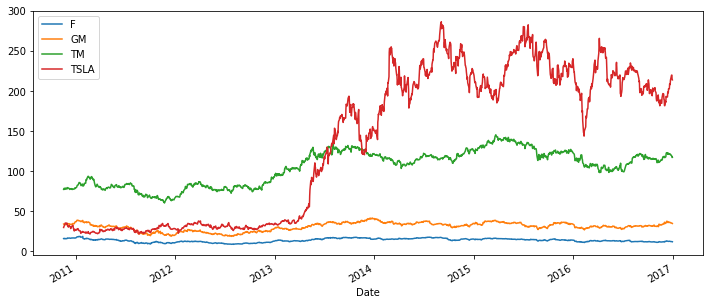

In [3]:
%matplotlib inline

from pandas_datareader import data
import pandas as pd

tickers = ["F", "TM", "GM", "TSLA"]

first_date = '2009-01-01'
last_date = '2016-12-31'


stock_panel = data.DataReader(tickers, 'google', first_date, last_date)

stock_df = stock_panel.Close.dropna()
stock_df.plot(figsize=(12, 5))

In [4]:
#this dataframe indicates if the stock was higher in 180 days
classes = (stock_df.shift(-180) > stock_df).astype(int)

X = stock_panel.to_frame()
classes = classes.unstack()
classes = classes.swaplevel(0, 1).sort_index()
classes = classes.to_frame()
classes.index.names = ['Date', 'minor']
data = X.join(classes).dropna()
data.rename(columns={0: 'is_higher'}, inplace=True)
data.head()

Open   High    Low  Close       Volume  is_higher
Date       minor                                                    
2010-11-18 F      16.77  16.87  16.05  16.12  256937875.0        0.0
           GM     35.00  35.99  33.89  34.19  458097672.0        0.0
           TM     77.36  77.51  76.83  77.29     992235.0        0.0
           TSLA   30.67  30.74  28.92  29.89     956248.0        0.0
2010-11-19 F      16.02  16.38  15.83  16.28  130323560.0        0.0

In [5]:
import patsy
X = patsy.dmatrix("Open + High + Low + Close + Volume + is_higher - 1", data.reset_index(),return_type='dataframe')
X.head()

,Open,High,Low,Close,Volume,is_higher
0,16.77,16.87,16.05,16.12,256937875.0,0.0
1,35.00,35.99,33.89,34.19,458097672.0,0.0
2,77.36,77.51,76.83,77.29,992235.0,0.0
3,30.67,30.74,28.92,29.89,956248.0,0.0
4,16.02,16.38,15.83,16.28,130323560.0,0.0


In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(X.iloc[:, :-1], X.iloc[:, -1]);

In [7]:
from sklearn.metrics import classification_report
print(classification_report(X.iloc[:, -1].values,lda.predict(X.iloc[:, :-1])))

             precision    recall  f1-score   support

        0.0       0.64      0.81      0.72      3432
        1.0       0.64      0.42      0.51      2727

avg / total       0.64      0.64      0.62      6159



### Using QDA and SGD for classification 

In [8]:
%matplotlib inline

from pandas_datareader import data
import pandas as pd

tickers = ["F", "TM", "GM", "TSLA"]

first_date = '2009-01-01'
last_date = '2016-12-31'


stock_panel = data.DataReader(tickers, 'google', first_date, last_date)

stock_df = stock_panel.Close.dropna()

classes = (stock_df.shift(-180) > stock_df).astype(int)

X = stock_panel.to_frame()
classes = classes.unstack()
classes = classes.swaplevel(0, 1).sort_index()
classes = classes.to_frame()
classes.index.names = ['Date', 'minor']
data = X.join(classes).dropna()
data.rename(columns={0: 'is_higher'}, inplace=True)

import patsy
X = patsy.dmatrix("Open + High + Low + Close + Volume + is_higher - 1", data.reset_index(),return_type='dataframe')

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\google\daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)


In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
qda = QDA()

qda.fit(X.iloc[:, :-1], X.iloc[:, -1])
predictions = qda.predict(X.iloc[:, :-1])
predictions.sum()

2686.0

In [10]:
from sklearn.metrics import classification_report
print(classification_report(X.iloc[:, -1].values, predictions))

             precision    recall  f1-score   support

        0.0       0.65      0.66      0.65      3432
        1.0       0.56      0.55      0.56      2727

avg / total       0.61      0.61      0.61      6159



In [11]:
from sklearn.model_selection import ShuffleSplit
import scipy.stats as sp

shuffle_split_inst = ShuffleSplit()

for test, train in shuffle_split_inst.split(X):
      train_set = X.iloc[train]
      train_close = train_set.Close

      train_0 = train_close[~train_set.is_higher.astype(bool)]
      train_1 = train_close[train_set.is_higher.astype(bool)]

      test_set = X.iloc[test]
      test_close = test_set.Close.values

ll_0 = sp.norm.pdf(test_close, train_0.mean())
ll_1 = sp.norm.pdf(test_close, train_1.mean())

(ll_0 > ll_1).mean()

0.19393830055926395

In [12]:
from sklearn import datasets
X, y = datasets.make_classification(n_samples = 500)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)


from sklearn import linear_model
sgd_clf = linear_model.SGDClassifier()
#As usual, we'll fit the model:
sgd_clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,sgd_clf.predict(X_test))

0.8

### Classifying documents with Naive Bayes

In [15]:
from sklearn.datasets import fetch_20newsgroups
categories = ["rec.autos", "rec.motorcycles"]
newgroups = fetch_20newsgroups(categories=categories)
#take a look
print("\n".join(newgroups.data[:1]))

From: gregl@zimmer.CSUFresno.EDU (Greg Lewis)
Subject: Re: WARNING.....(please read)...
Keywords: BRICK, TRUCK, DANGER
Nntp-Posting-Host: zimmer.csufresno.edu
Organization: CSU Fresno
Lines: 33

In article <1qh336INNfl5@CS.UTK.EDU> larose@austin.cs.utk.edu (Brian LaRose) writes:
>This just a warning to EVERYBODY on the net.  Watch out for
>folks standing NEXT to the road or on overpasses.   They can
>cause SERIOUS HARM to you and your car.  
>
>(just a cliff-notes version of my story follows)
>
>10pm last night, I was travelling on the interstate here in
>knoxville,  I was taking an offramp exit to another interstate
>and my wife suddenly screamed and something LARGE hit the side
>of my truck.  We slowed down, but after looking back to see the
>vandals standing there, we drove on to the police station.
>
>She did get a good look at the guy and saw him "cock his arm" with
>something the size of a cinderblock, BUT I never saw him. We are 
>VERY lucky the truck sits up high on the road; i

In [16]:
newgroups.target_names

['rec.autos', 'rec.motorcycles']

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer()
bow = count_vec.fit_transform(newgroups.data)

In [18]:
bow

<1192x19177 sparse matrix of type '<class 'numpy.int64'>'
	with 164296 stored elements in Compressed Sparse Row format>

In [20]:
import numpy as np

In [21]:
bow = np.array(bow.todense())

In [22]:
words = np.array(count_vec.get_feature_names())
words[bow[0] > 0][:5]

array(['10pm', '1qh336innfl5', '33', '93740',
       '___________________________________________________________________'],
      dtype='<U79')

In [23]:
'10pm' in newgroups.data[0].lower()

True

In [24]:
'1qh336innfl5' in newgroups.data[0].lower()

True

In [41]:
from sklearn import naive_bayes
clf = naive_bayes.GaussianNB().fit(X_train, y_train)

In [42]:
X = bow
y = newgroups.target

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5,stratify=y)

In [44]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,clf.predict(X_test) )

0.9765100671140939

In [45]:
from sklearn.datasets import fetch_20newsgroups
mn_categories = ["rec.autos", "rec.motorcycles", "talk.politics.guns"]
mn_newgroups = fetch_20newsgroups(categories=mn_categories)

In [46]:
mn_bow = count_vec.fit_transform(mn_newgroups.data)
mn_bow = np.array(mn_bow.todense())

X = mn_bow
y = mn_newgroups.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5,stratify=y)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,clf.predict(X_test) )

0.9643268124280783

### Label propagation with semi-supervised learning 

In [47]:
from sklearn import datasets
d = datasets.load_iris()

In [48]:
X = d.data.copy()
y = d.target.copy()
names = d.target_names.copy()
names = np.append(names, ['unlabeled'])
names

array(['setosa', 'versicolor', 'virginica', 'unlabeled'], dtype='<U10')

In [49]:
y[np.random.choice([True, False], len(y))] = -1

In [50]:
y[:10]

array([-1,  0, -1,  0, -1,  0,  0, -1, -1, -1])

In [51]:
names[y[:10]]

array(['unlabeled', 'setosa', 'unlabeled', 'setosa', 'unlabeled',
       'setosa', 'setosa', 'unlabeled', 'unlabeled', 'unlabeled'],
      dtype='<U10')

In [53]:
from sklearn import semi_supervised
lp = semi_supervised.LabelPropagation()
lp.fit(X, y)

LabelPropagation(alpha=None, gamma=20, kernel='rbf', max_iter=1000, n_jobs=1,
         n_neighbors=7, tol=0.001)

In [56]:
preds = lp.predict(X)
(preds == d.target).mean()

0.9866666666666667

In [64]:
from scipy.sparse import csgraph
ls = semi_supervised.LabelSpreading()
ls.fit(X, y)

LabelSpreading(alpha=0.2, gamma=20, kernel='rbf', max_iter=30, n_jobs=1,
        n_neighbors=7, tol=0.001)

In [65]:
(ls.predict(X) == d.target).mean()

0.98